<center><h1>Analisis de series temporales</h1></center>
<center><h2>Laboratorio 2</h2></center>
<br>

<h6>1) Levantar los datos desde el archivo dataset/demanda.csv. Los mismos fueron extraídos de los datos del informe mensual en http://portalweb.cammesa.com/memnet1/Pages/descargas.aspx </h6>
<h6>2) Explorar los datos y visualizar descomposición de datos</h6>
<h6>3) Modelar con Holt Winters Smoothing con diferentes parámetros</h6>
<h6>4) Visualizar los resultados y evaluar su poder predictivo, comparando ambos modelos</h6>


In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [15, 5]

## 1) Levantar los Datos: Demanda de CAMMESA

In [4]:
data = pd.read_csv('datasets/demanda.csv', index_col='TIPO', parse_dates=True, dayfirst=True)
data.tail()

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
TIPO,,,,
2019-03-01,4004709.444,3044854.983,3072063.284,1.012163e+07
2019-04-01,3652724.519,2892482.731,3029687.889,9.574895e+06
2019-05-01,4356836.823,2973830.213,3055527.035,1.038619e+07
2019-06-01,4816838.191,2937048.667,2897618.673,1.065151e+07
2019-07-01,5704951.016,3288949.873,3035538.422,1.202944e+07


In [5]:
y = data['TOTAL'].copy()
y.index = y.index.to_period(freq='M')

ts = data['TOTAL']

In [6]:
data.describe().round(2)

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
count,79.00,79.00,79.00,79.00
mean,4551935.29,3113096.42,3187977.02,10853008.74
std,654164.93,206829.98,124659.74,816874.81
min,3239380.70,2809183.13,2897618.67,9307334.16
25%,3990580.45,2948084.14,3109179.19,10223259.40
50%,4470715.12,3070853.24,3199317.20,10706955.32
75%,5092450.46,3270751.91,3275571.56,11476364.98
max,6193110.21,3606989.07,3460879.97,12607552.72


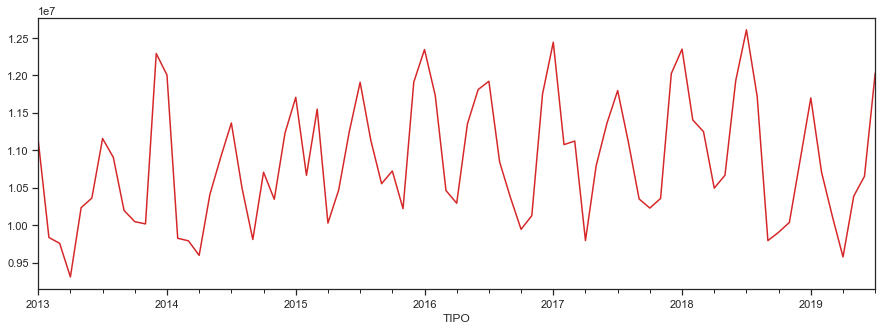

In [7]:
y.plot(color=red);

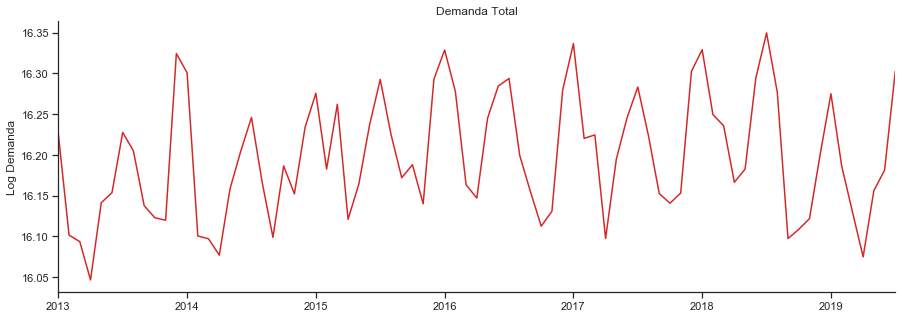

In [8]:
fig, ax= plt.subplots();
np.log(y).plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Log Demanda')
ax.set_title('Demanda Total')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

## 2) Explorar los datos y visualizar descomposición de series Temporales

Se utiliza el método X-13 ARIMA-SEATS para la descomposición de las series temporales.
Para más información sobre el método X-13 ARIMA-SEATS:
[US Census Bureau](https://www.census.gov/srd/www/x13as/).


Para que el software X-13 esté disponible para Python, se debe descargar del enlace anterior y extraer la carpeta comprimida en su computadora. La biblioteca <TT>statsmodels</TT> tiene una función que interactúa con este software, y la forma más fácil de hacerlo funcionar es copiar el ejecutable <TT>x13as</TT> en la misma carpeta de su notebook.

El X-13 es la versión actual del método X-12-ARIMA descrito en el [libro de texto] (https://www.otexts.org/fpp/6/4). La única limitación es que el software X-13 realiza ajustes de efecto de calendario basados en el calendario de EE.UU. de forma predeterminada, aunque es posible reconfigurarlo en otros calendarios.

In [9]:
decomposition = sm.tsa.x13_arima_analysis(ts,x12path='.')

C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\statsmodels\tsa\x13.py:187: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


El método <TT>dir</TT> permite controlar los resultados disponibles.

In [10]:
dir(decomposition)[-6:]

['observed', 'plot', 'results', 'seasadj', 'stdout', 'trend']

Por ejemplo, si queremos graficar la serie con la componente estacional removida se consulta <TT>seasadj</TT>

In [11]:
decomposition.seasadj.tail()

TIPO
2019-03-01    1.025205e+07
2019-04-01    1.045484e+07
2019-05-01    1.042364e+07
2019-06-01    1.021774e+07
2019-07-01    1.089532e+07
Name: seasadj, dtype: float64

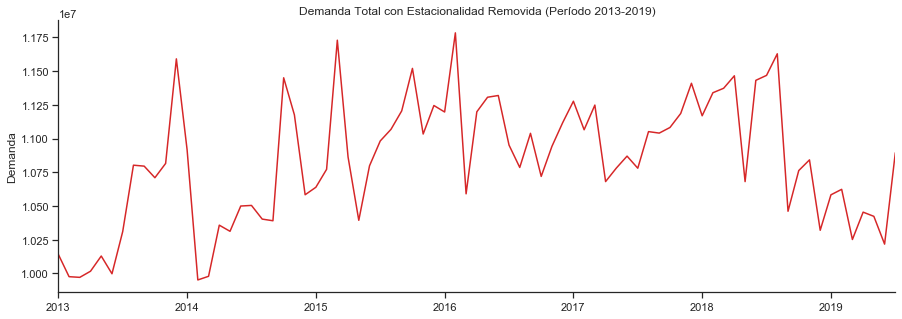

In [12]:
fig, ax= plt.subplots();
decomposition.seasadj.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Demanda')
ax.set_title('Demanda Total con Estacionalidad Removida (Período 2013-2019)')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

El módulo <TT>plotting</TT> tienen una función práctica para graficar las distintas componentes de la serie temporal

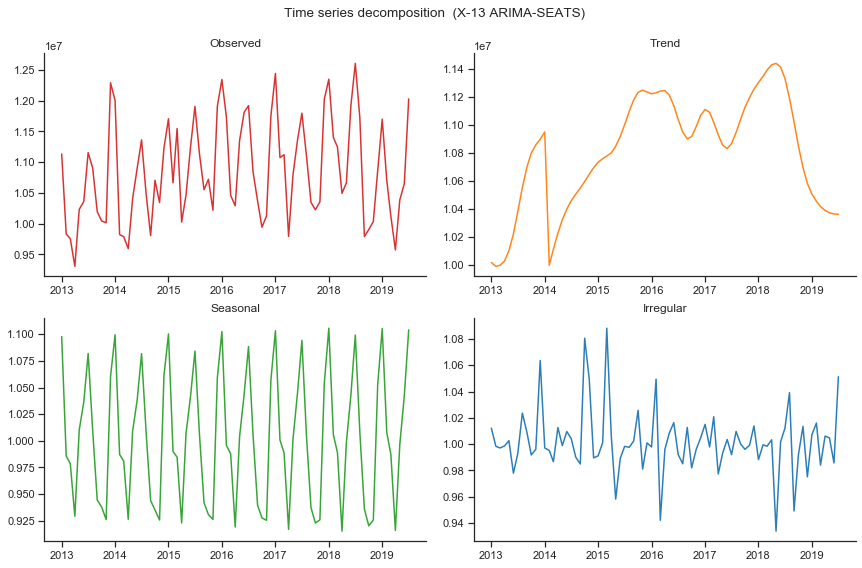

In [13]:
from plotting import plot_components_x13
plot_components_x13(decomposition)
plt.show()

El software X-13-ARIMA genera un análisis muy detallado de la serie temporal, que se almacena en el atributo <TT>results</TT>. Puede verse con el comando <TT>print(decomposition.results)</TT>, pero debido al tamaño del archivo, se recomienda guardarlo en un archivo de texto y abrirlo en otro lugar.

In [14]:
f=open('x13results.txt', mode='w+')
f.write(decomposition.results)
f.close()

En caso de que no pueda trabajar con el software de descomposición X13, hay una descomposición más básica disponible de la siguiente manera.

In [15]:
basic_decomposition = sm.tsa.seasonal_decompose(ts, model='additive', freq=6) #multiplicative y freq=12

## Exponential Smoothing con Tendencia corregida

Antes de modelar y pronosticar la serie original, las siguientes celdas demuestran la aplicación del método Exponential Smoothing con Tendencia corregida, enfocándose en la serie observada corregida estacionalmente.

In [16]:
ts=decomposition.seasadj
ts.index=ts.index.to_period(freq='M')

In [17]:
model_sm = sm.tsa.Holt(ts).fit()
smoothed_sm = model_sm.fittedvalues
alpha_sm = model_sm.model.params['smoothing_level']
betha_sm = model_sm.model.params['smoothing_slope']
mse_sm = sm.tools.eval_measures.mse(ts,smoothed_sm)
print(' Smoothing parameter: alpha  {0:.3f}'.format(alpha_sm))
print(' Smoothing parameter: betha  {0:.3f}'.format(betha_sm))
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_sm))

 Smoothing parameter: alpha  0.384
 Smoothing parameter: betha  0.000
 In-sample fit:
 MSE               139388082870.780


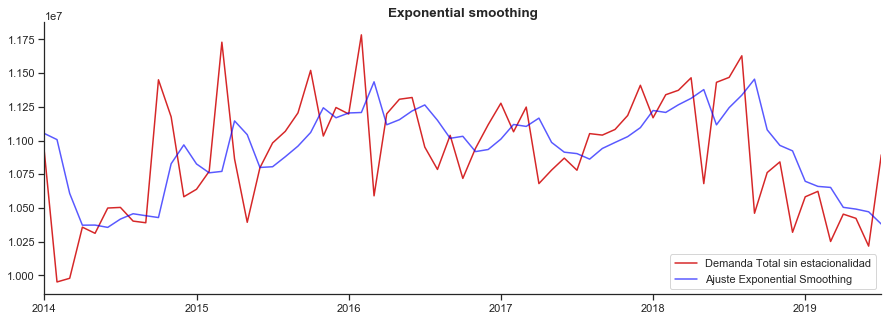

In [18]:
#smoothed=pd.Series(smoothed_sm, index=ts.index)

fig, ax= plt.subplots();#figsize=(9,6))

ts['2014':].plot(color='#D62728', label='Demanda Total sin estacionalidad')
smoothed_sm['2014':].plot(color='blue', label='Ajuste Exponential Smoothing', alpha=0.65)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Users\javi\.conda\envs\diplodatos\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


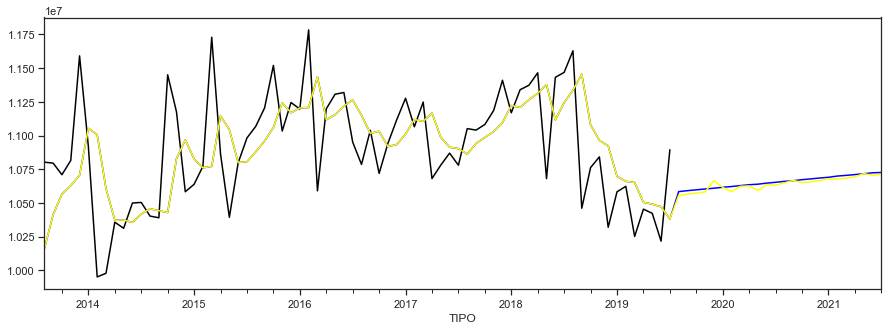

In [19]:
h=24
w=h*3
data = ts
model = sm.tsa.Holt
pred_index = data.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_fit = None
for i in range(0,h):
    current = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current).fit()
    if i==0:
        orig_fit = expanding.fittedvalues
    rolling = model(current.tail(w)).fit()
    pred_expanding.update(expanding.forecast(1))
    pred_rolling.update(rolling.forecast(1))
ax = data[-w:].plot(color='black');#figsize=(9,6))
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_fit[-w:],pred_rolling]).plot(ax=ax,color='yellow');

## Holt-winters exponential smoothing

A continuación, estimamos varias especificaciones. El AIC sugiere un modelo multiplicativo sin amortiguación para la serie original, pero necesitaríamos hacer un ajuste de probabilidad o una comparación de conjunto de validación para seleccionar entre este método y un modelo aditivo para una transformación logarítmica.

In [20]:
def hw_summary(model_sm):
    alpha_sm = model_sm.model.params['smoothing_level']
    betha_sm = model_sm.model.params['smoothing_slope']
    delta_sm = model_sm.model.params['smoothing_seasonal']
    mse_sm = sm.tools.eval_measures.mse(model_sm.data.endog,model_sm.fittedvalues)
    rmse_sm = sm.tools.eval_measures.rmse(model_sm.data.endog,model_sm.fittedvalues)
    print(' Smoothing parameter: alpha  {0:.3f}'.format(alpha_sm))
    print(' Smoothing parameter: betha  {0:.3f}'.format(betha_sm))
    print(' Smoothing parameter: delta  {0:.3f}'.format(delta_sm))
    print(' In-sample fit:')
    print(' MSE               {0:.3f}'.format(mse_sm))
    print(' RMSE               {0:.3f}'.format(rmse_sm))
    return rmse_sm

Holt-Winters sumando la estacionalidad, sumando la tendencia y sin amortiguamiento.

In [21]:
ahw_sm=sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, 
                                   seasonal='add', seasonal_periods=6).fit()

In [22]:
hw_summary(ahw_sm);

 Smoothing parameter: alpha  0.271
 Smoothing parameter: betha  0.071
 Smoothing parameter: delta  0.000
 In-sample fit:
 MSE               202157574304.833
 RMSE               449619.366


Holt-Winters multiplicando la estacionalidad, sumando la tendencia y sin amortiguamiento.

In [23]:
mhw_sm=sm.tsa.ExponentialSmoothing(y, trend='add', damped=False, seasonal='mul', seasonal_periods=6).fit()
hw_summary(mhw_sm);

 Smoothing parameter: alpha  0.269
 Smoothing parameter: betha  0.071
 Smoothing parameter: delta  0.000
 In-sample fit:
 MSE               196610333068.713
 RMSE               443407.638


Holt-Winters multiplicando la estacionalidad, sumando la tendencia y con amortiguamiento.

In [24]:
mhw_damped=sm.tsa.ExponentialSmoothing(y, trend='add', damped=True, seasonal='mul', seasonal_periods=6).fit()
hw_summary(mhw_damped);

 Smoothing parameter: alpha  0.177
 Smoothing parameter: betha  0.000
 Smoothing parameter: delta  0.000
 In-sample fit:
 MSE               179461663600.964
 RMSE               423629.158


La serie suavizada basada en el método multiplicativo sigue muy de cerca la serie original.

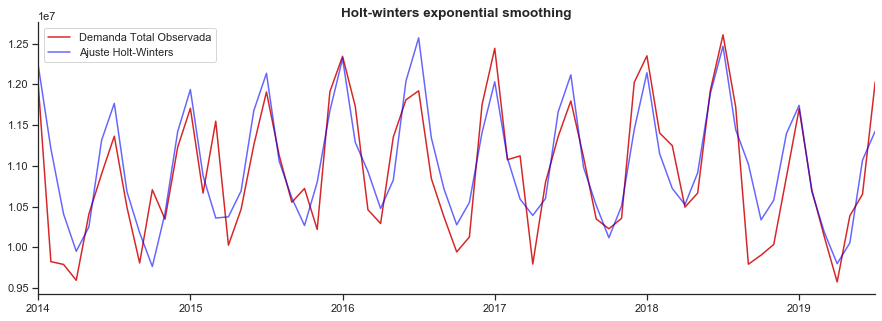

In [25]:
smoothed=pd.Series(mhw_sm.fittedvalues, index=y.index)

fig, ax= plt.subplots();

y['2014':].plot(color='#D62728', label='Demanda Total Observada')
smoothed['2014':].plot(color='blue', label='Ajuste Holt-Winters', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

## Diagnóstico del modelo

Basamos los diagnósticos en el modelo multiplicativo Holt-Winters. 
El modelo parece capturar adecuadamente los patrones de series temporales en los datos, lo que lleva a correlaciones residuales pequeñas e insignificantes. Además, los residuos no se presentan con media cero y aparentemente sin tendencia ni rasgos de estacionalidad. Por otra parte, los residuos siguen aproximadamente una distribución normal. Todo esto, permite afirmar que el ajuste con Holt-Winters es adecuado.

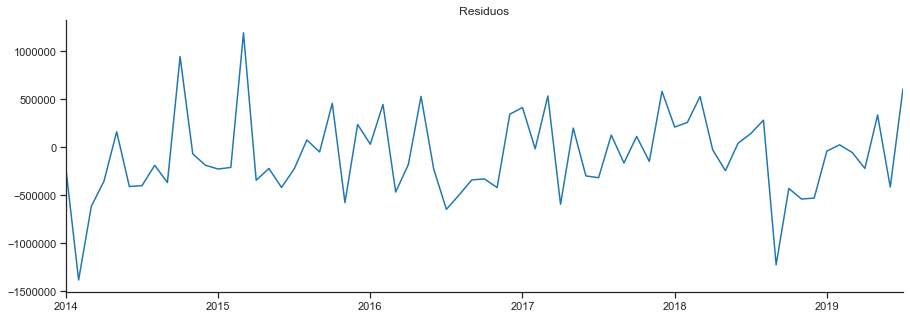

In [26]:
resid = (y-mhw_sm.fittedvalues)[12:] # we remove the first 12 observations as they are for initialisitation only

fig, ax= plt.subplots();
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residuos')
sns.despine()
plt.show()

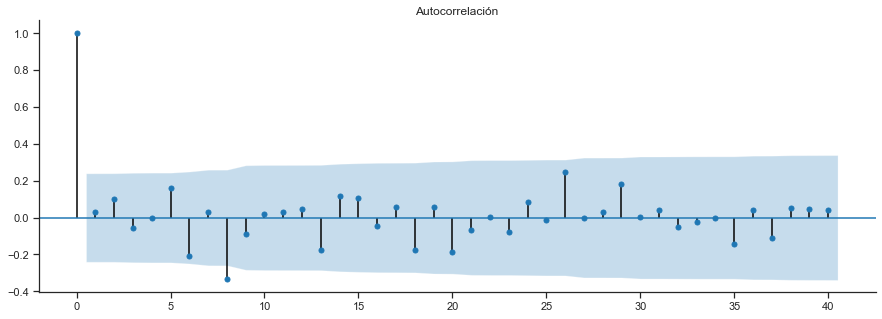

In [27]:
fig, ax = plt.subplots();
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax)
ax.set_title('Autocorrelación')
sns.despine()
plt.show()

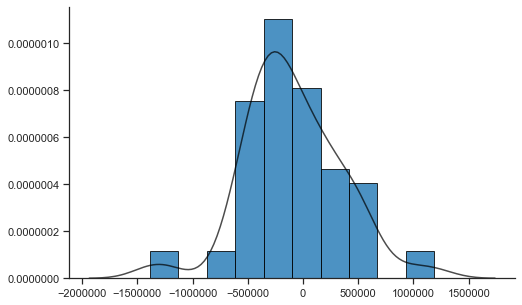

In [28]:
from plotting import histogram

histogram(resid)
plt.show()


## Validación del modelo

El análisis de pronóstico en tiempo real sugiere que el modelo de aditivo de logaritmos de Holt Winters para la serie en logaritmos es el método más preciso para los pronósticos de un paso adelante. Los pronósticos de Holt-Winters funcionan significativamente mejor que una caminata aleatoria estacional (Seasonal Random Walk).

In [29]:
start_val = y.index[-round(len(y)/6*.2)*6]
start_val

Period('2018-02', 'M')

In [30]:
# Real time forecasting 

validation=y[start_val:].index
start = y.index.get_loc(start_val) 

pred1 = [] # seasonal random walk
pred2 = [] # additive holt winters
pred3 = [] # multiplicative holt winters
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-12]) # seasonal random walk forecast
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='add', seasonal_periods=12).fit()
    pred2.append(model.forecast(1)[0]) # additive holt winters forecast
    
    model = sm.tsa.ExponentialSmoothing(y.iloc[:i], trend='add', damped=False, seasonal='mul', seasonal_periods=12).fit()
    pred3.append(model.forecast(1)[0]) # multiplicate holt winters forecast
    

columns=['Seasonal RW', 'Additive', 'Multiplicative', 'Actual']
results = np.vstack([pred1,pred2,pred3,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

In [31]:
from scipy import stats

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(len(results.columns)-1):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results.iloc[:,i], results.iloc[:,-1])
    table.iloc[i,1] = (results.iloc[:,i] - results.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
Seasonal RW,703536.793,157510.477
Additive,580604.604,131090.728
Multiplicative,531831.803,126660.808


## Pronóstico

Finalmente, generamos un pronóstico de 1 año usando el modelo ajustado de Holt-Winters.

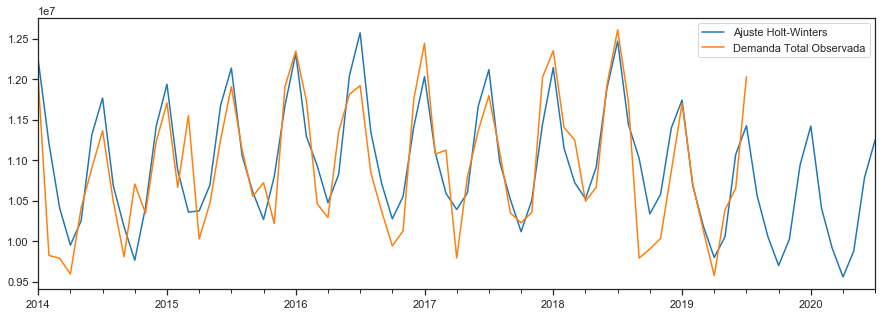

In [34]:
h=12

model = sm.tsa.ExponentialSmoothing(y, 
                    trend='add', damped=False, seasonal='mul', seasonal_periods=6).fit()

forecast = model.forecast(h)

plot = pd.DataFrame()
plot['Ajuste Holt-Winters'] = pd.concat([model.fittedvalues, forecast])
plot['Demanda Total Observada'] = y

plot['2014':].plot();